In [3]:
import tensorflow as tf
from tensorflow import keras 
import os
import random
import numpy as np

from tqdm import tqdm 

from skimage.io import imread, imshow, imsave
from skimage.draw import polygon2mask
from skimage.transform import resize
import matplotlib.pyplot as plt

2025-04-02 01:48:25.089551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 01:48:25.120992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-02 01:48:25.595198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
train_ids = next(os.walk(TRAIN_PATH))[1]

dir_img = os.getcwd() + "/dataset/img"
dir_mask = os.getcwd() + "/dataset/mask"

# path = TRAIN_PATH + train_ids[0]
# img = imread(path + '/images/' + train_ids[0] + '.png')[:,:,:3]
# plt.imshow(img)
# plt.show()

number = 0
for i,id_ in enumerate(train_ids) :
    if i == 100 : break
    # print(f" number: {number} : i: {i}")
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    N,M,_ = img.shape
    mask = np.zeros((N,M), dtype=np.uint8)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask = np.maximum(mask, mask_)
    n = N // IMG_WIDTH; m = M // IMG_HEIGHT
    while n > 0 : # filas
        if m == 0 : m = M // IMG_HEIGHT
        while m > 0 : # columnas
            imsave(dir_img + f'/img_{str(number).zfill(3)}.png', img[(n-1)*IMG_WIDTH:n*IMG_WIDTH,(m-1)*IMG_HEIGHT:m*IMG_HEIGHT]) 
            imsave(dir_mask + f'/mask_{str(number).zfill(3)}.png', mask[(n-1)*IMG_WIDTH:n*IMG_WIDTH,(m-1)*IMG_HEIGHT:m*IMG_HEIGHT])
            m -= 1; number += 1
        n -= 1

In [5]:
TRAIN_PATH = 'stage1_train/'
train_ids = next(os.walk(TRAIN_PATH))[1]
len(train_ids)

670

In [4]:
# Rutas de las carpetas de imágenes y máscaras
dir_img = os.getcwd() + "/dataset/img"
dir_mask = os.getcwd() + "/dataset/mask"

# Obtener listas de archivos
image_files = sorted([os.path.join(dir_img, f) for f in os.listdir(dir_img)])
mask_files = sorted([os.path.join(dir_mask, f) for f in os.listdir(dir_mask)])
padds = [[94, 94], [94, 94], [0, 0]]

# Función para cargar y preprocesar una imagen y máscara
def load_and_preprocess(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Ajusta los canales según tus imágenes
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar la imagen

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Ajusta los canales según tus máscaras
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalizar la máscara

    image = tf.pad(image, paddings = padds, mode = "REFLECT")

    return image, mask

# Crear el dataset
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
dataset = dataset.map(load_and_preprocess)

# Configurar el dataset para el entrenamiento
BATCH_SIZE = 2
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=len(image_files))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Entrenar el modelo
EPOCHS = 5

validation_split = 0.2
validation_size = int(len(image_files) * validation_split)
train_dataset = dataset.skip(validation_size // BATCH_SIZE)
validation_dataset = dataset.take(validation_size // BATCH_SIZE)

(32, 444, 444, 3)
(32, 256, 256, 1)


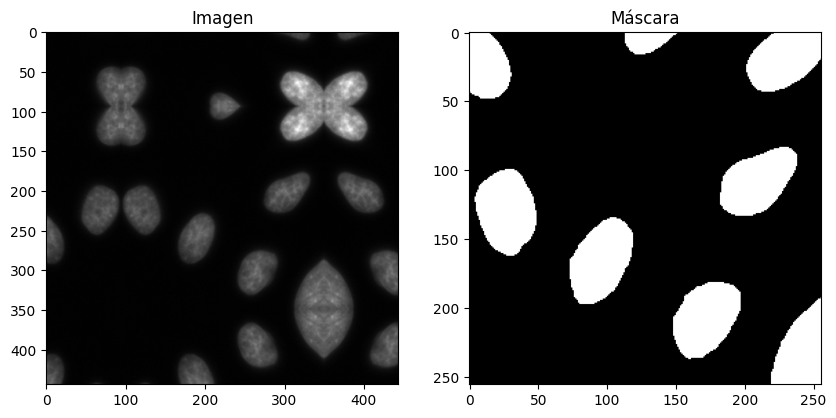

2025-04-01 08:23:37.019632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
for image, mask in dataset.take(1):
    # Visualizar la imagen
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.utils.array_to_img(image[1]))  # Mostrar la imagen
    print(image.shape)
    plt.title("Imagen")

    # Visualizar la máscara
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.utils.array_to_img(mask[1]), cmap="gray")  # Mostrar la máscara en escala de grises
    print(mask.shape)
    plt.title("Máscara")
    plt.show()

### Vemos y configuramos la GPU: 

Definimos hiperparametros y rutas necesarias: 

In [43]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

#### Transformamos las imagenes tanto de Entrenamiento como de Validadion y Test

Dado el tamanio de la img, la convertimos a 128 x 128, para poder llevarlo a los dimensiones del modelo. 

#### Importamos el modelo.

In [38]:
from model import Unet_model

GPU disponible:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
# config model
N = 256 + 2*94
m = Unet_model(N, N, 3, base = 8)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Ajusta la tasa de aprendizaje
m.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
history = m.fit(train_dataset, epochs = EPOCHS, validation_data=validation_dataset)

Epoch 1/5


I0000 00:00:1743560470.532034   31046 service.cc:145] XLA service 0x76b01c009710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743560470.532055   31046 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-01 23:21:10.604438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-01 23:21:11.050647: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


13/66 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7528 - loss: 0.6824

I0000 00:00:1743560475.275761   31046 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 88 bytes spill stores, 88 bytes spill loads

I0000 00:00:1743560475.280500   31046 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8223 - loss: 0.6068 - val_accuracy: 0.8297 - val_loss: 0.4844
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8470 - loss: 0.4028 - val_accuracy: 0.8508 - val_loss: 0.2666
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8821 - loss: 0.2596 - val_accuracy: 0.8800 - val_loss: 0.2630
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9214 - loss: 0.1994 - val_accuracy: 0.9204 - val_loss: 0.1971
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9421 - loss: 0.1599 - val_accuracy: 0.9416 - val_loss: 0.1519


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predict


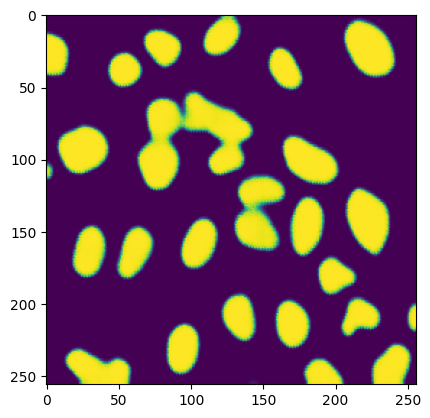

mask


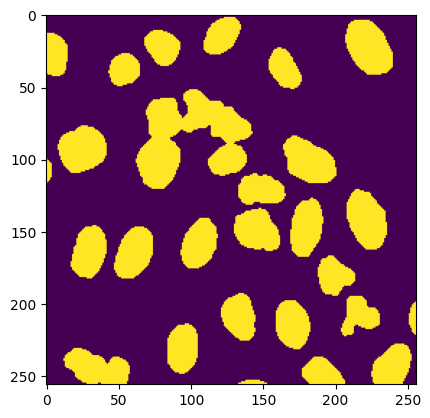

In [56]:
for img, mask in validation_dataset.take(1):
    img = tf.expand_dims(img[0], axis=0)
    res = m.predict(img)
    # print(img[0].shape)
    print("predict")
    plt.imshow(res[0])
    plt.show()
    print("mask")
    plt.imshow(mask[0])
    plt.show()
    break

#### Mostramos aleatoriamente la prediccion de una img del dataset de Entrenamiento y otro de Validacion

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


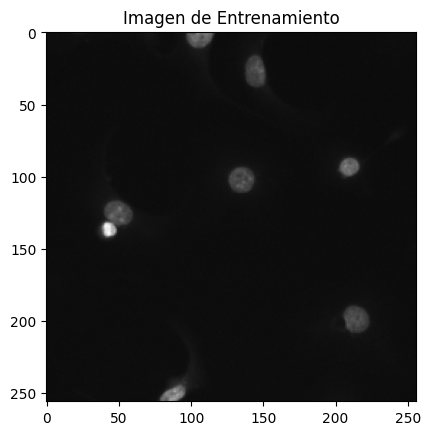

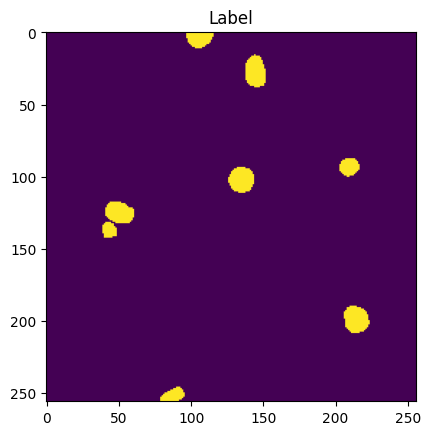

/tmp/ipykernel_4134/422518268.py:19: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_train_t[ix]))
/home/kenetc/tf/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


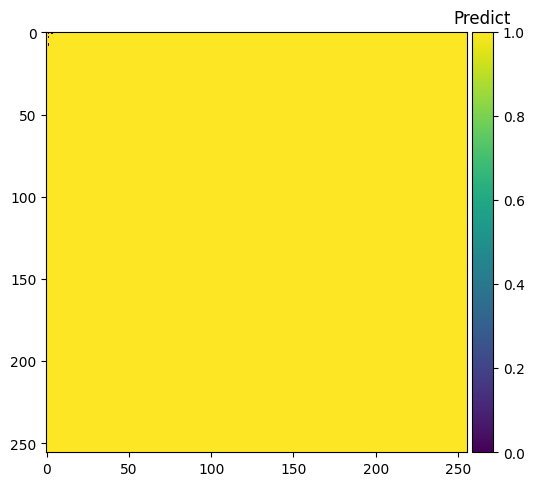

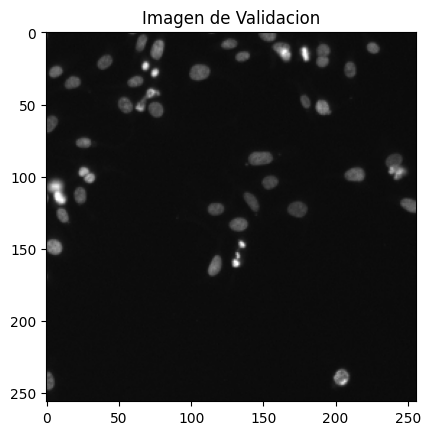

/tmp/ipykernel_4134/422518268.py:28: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))


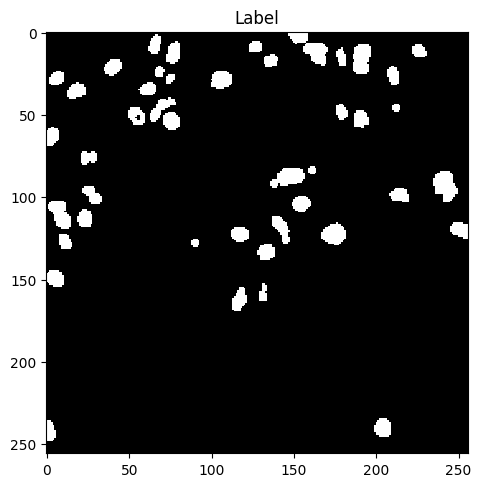

/tmp/ipykernel_4134/422518268.py:31: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_val_t[ix]))
/home/kenetc/tf/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


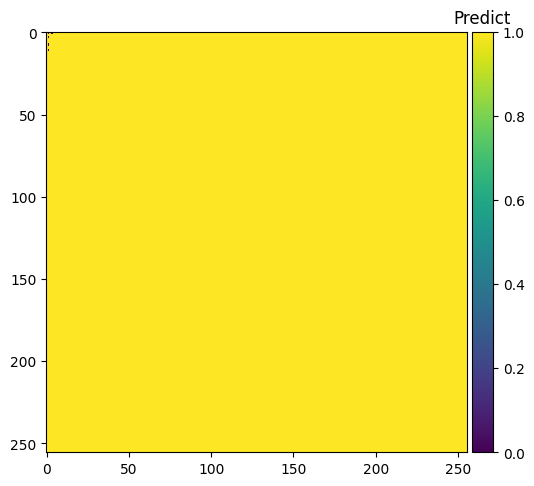

In [36]:
idx = random.randint(0, l)

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Tomamos aleatoriamente una img de train 
ix = random.randint(0, len(preds_train_t)-1)
plt.imshow(X_train[ix])
plt.title("Imagen de Entrenamiento")
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.title("Label")
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.title("Predict")
plt.show()

# Tomamos aleatoriamente una img de val
ix = 0#random.randint(0, len(preds_val_t))
plt.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.title("Imagen de Validacion")
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.title("Label")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predict")
plt.show()

# # Tomamos aleatoriamente una img de test
# ix = random.randint(0, len(preds_test_t))
# plt.imshow(X_test[ix])
# plt.title("Imagen de Test")
# plt.show()
# plt.imshow(np.squeeze(preds_test_t[ix]))
# plt.title("Predict")
# plt.show()

### Probamos con las imagenes de http://digitalpapsdb.exactas.uba.ar/

Hacemos el **resize** de las imagenes.

In [9]:
PAPs_PATH = 'Paps'
paps_ids = next(os.walk(PAPs_PATH))[1]

img_paps = np.zeros((len(paps_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Resizing Paps images') 
for n, id_ in tqdm(enumerate(paps_ids), total=len(paps_ids)):
    path = PAPs_PATH +'/'+ id_
    img = imread(path +'/'+ id_[:-3]+'.png')[:,:,:IMG_CHANNELS]
    #print(path +'/'+ id_[:-3] + '.png')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_paps[n] = img

Resizing Paps images


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


#### Predict

In [10]:
paps_results = model.predict(img_paps, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [32]:
print("Vemos si tienen las mismas dimesiones")
print(img_paps[0].shape)
print(np.squeeze(paps_results[i]>0.5).shape)

# guardamos los predicts 
for n, id_ in tqdm(enumerate(paps_ids), total=len(paps_ids)):
    imsave(f"predict_{id_}.png", np.clip(paps_results[n][:,:,0] * 255, 0, 255).astype(np.uint8))
    #print(paps_results[i][:,:,0].shape)
    #print(paps_results[i][:,:,0].ndim)

Vemos si tienen las mismas dimesiones
(128, 128, 3)
(128, 128)


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 583.11it/s]


  0%|                                                    | 0/10 [00:00<?, ?it/s]

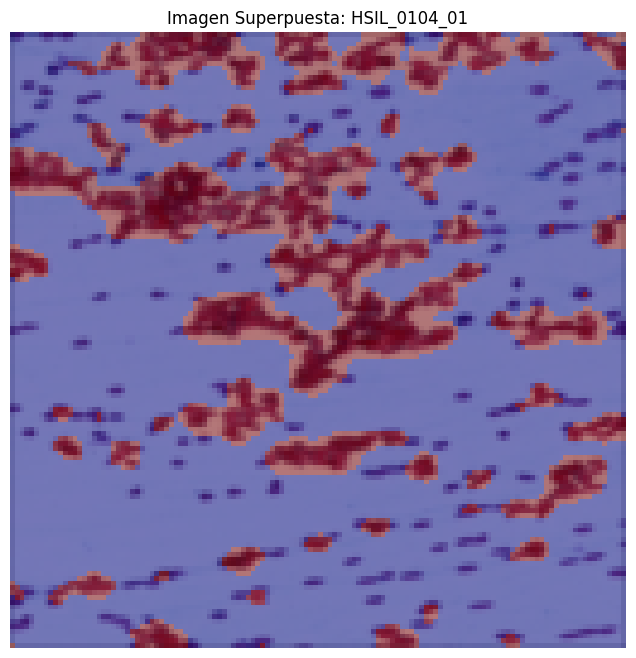

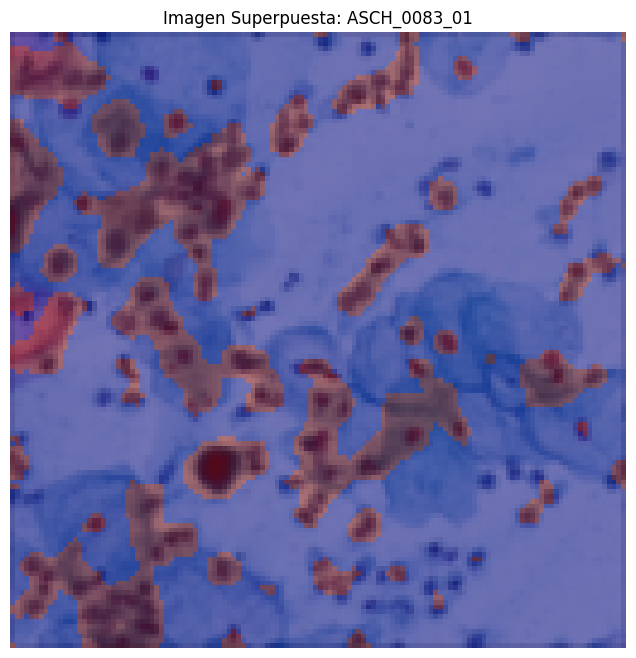

 20%|████████▊                                   | 2/10 [00:00<00:00, 15.22it/s]

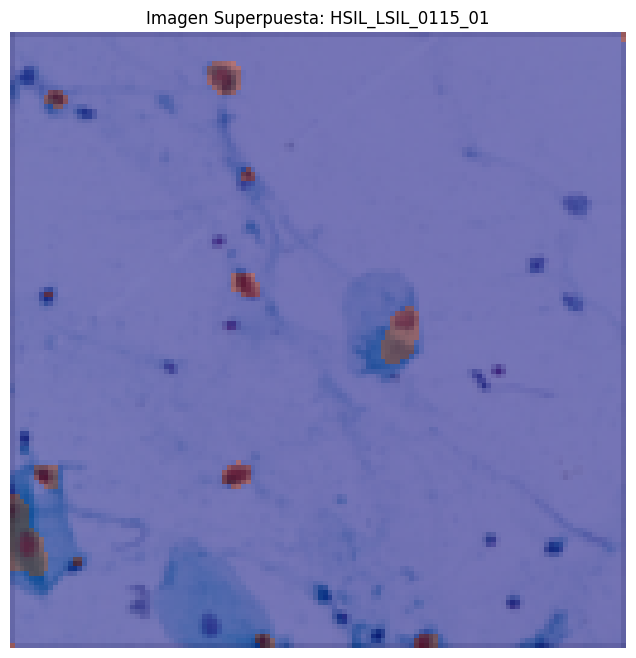

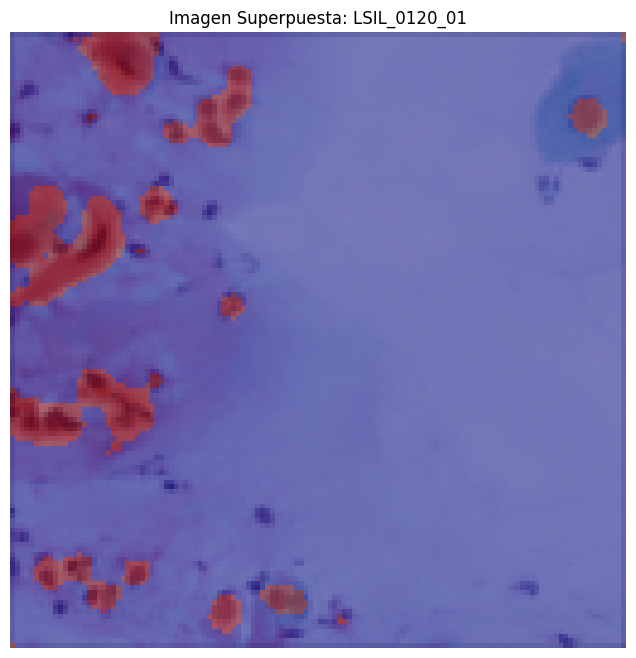

 40%|█████████████████▌                          | 4/10 [00:00<00:00, 15.65it/s]

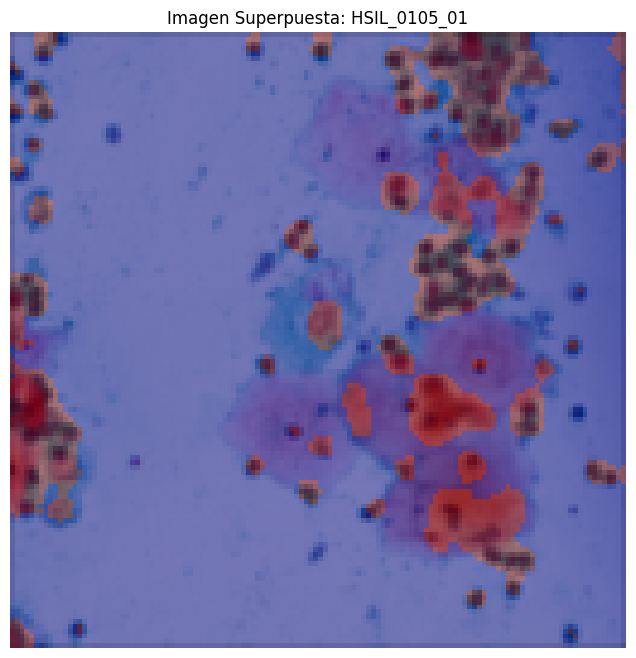

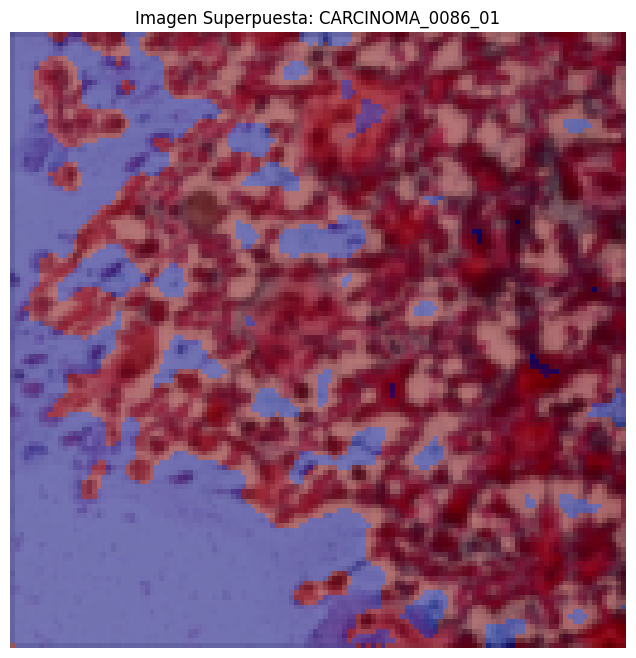

 60%|██████████████████████████▍                 | 6/10 [00:00<00:00, 15.83it/s]

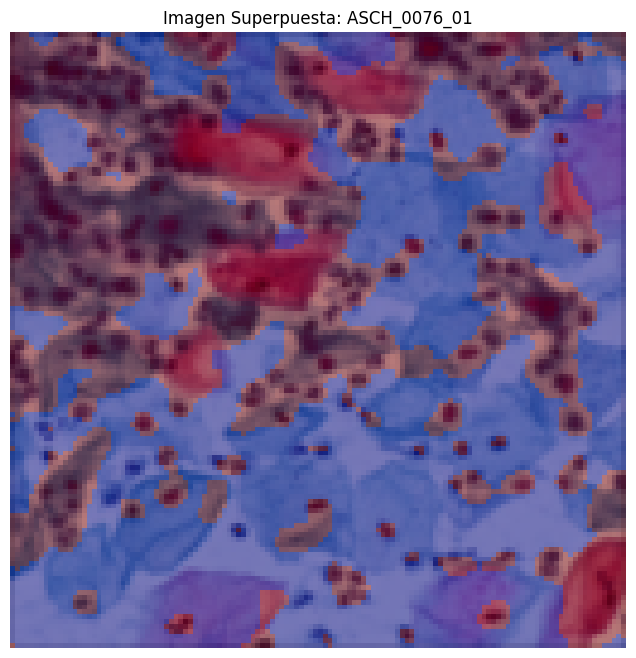

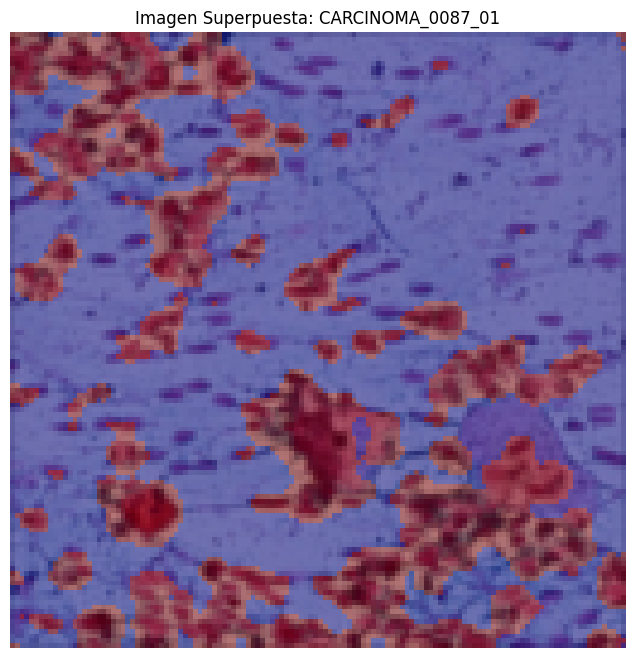

 80%|███████████████████████████████████▏        | 8/10 [00:00<00:00, 16.03it/s]

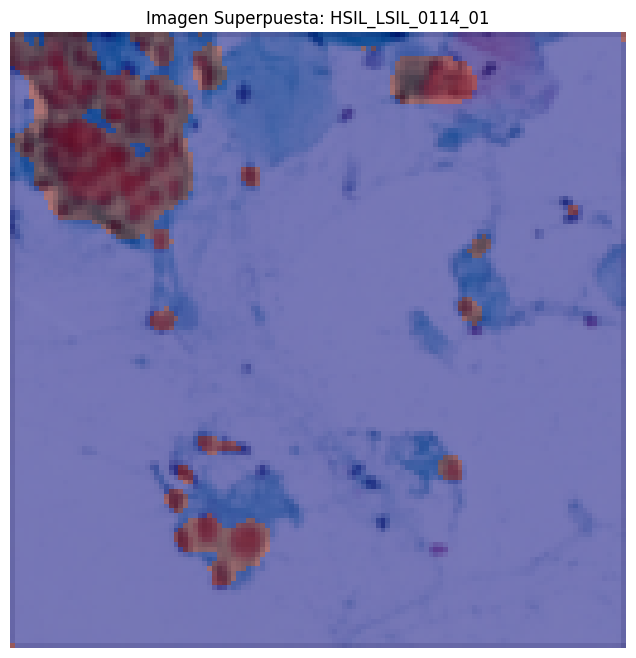

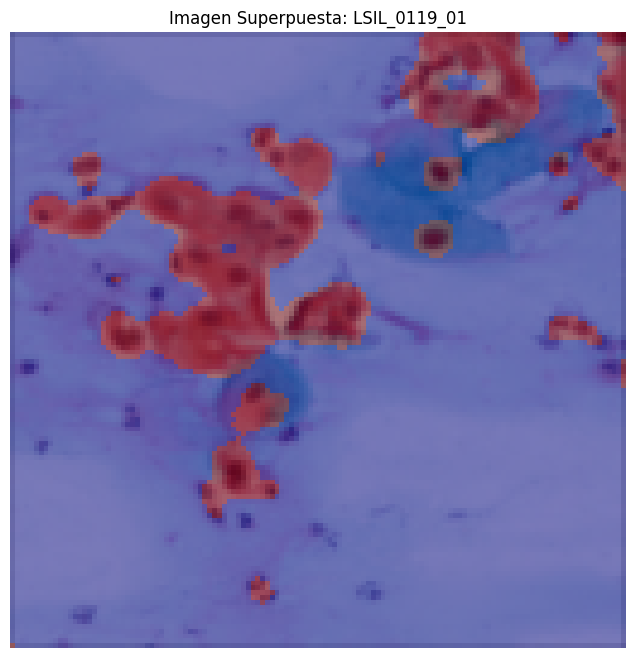

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.04it/s]


In [14]:
for n, id_ in tqdm(enumerate(paps_ids), total=len(paps_ids)):
    # Crear la figura para mostrar las tres imágenes superpuestas
    plt.figure(figsize=(8, 8))

    # Mostrar la imagen original
    plt.imshow(img_paps[n], cmap='gray')  # Usamos escala de grises para la imagen original
    plt.axis('off')  # Desactivar los ejes

    # Superponer la segmentación del citoplasma con colores llamativos
    plt.imshow(np.squeeze(paps_results[n]>0.5), cmap='jet', alpha=0.5)  # Transparencia del 50% para la segmentación

    # Título de la imagen
    plt.title(f"Imagen Superpuesta: {id_}")

    # Mostrar la imagen final
    #plt.savefig(f"Imagen Superpuesta: {id_}")
    plt.show()

In [78]:
path = os.getcwd() + "/archive/im_Dyskeratotic/im_Dyskeratotic"
img = imread(path + "/001.bmp")
N,M,_= img.shape
print(N / 256)
print(M / 256)
coords = np.loadtxt(path + "/001_nuc01.dat",delimiter=",")
mask = np.zeros((N,M), dtype = np.uint8)
contorno = np.array(coords, dtype=np.int32).reshape((-1, 1, 2))

6.0
8.0


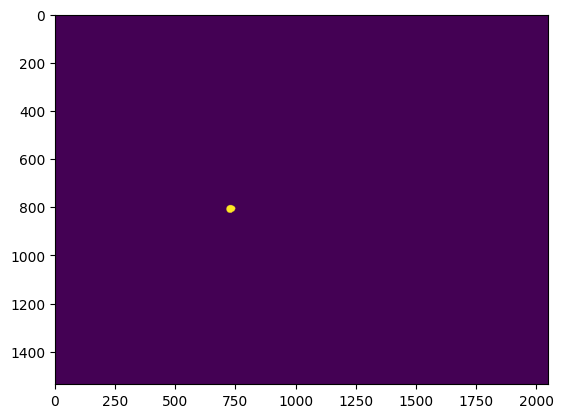

In [87]:
mask = polygon2mask((N,M),coords)
plt.imshow(mask)
plt.show()

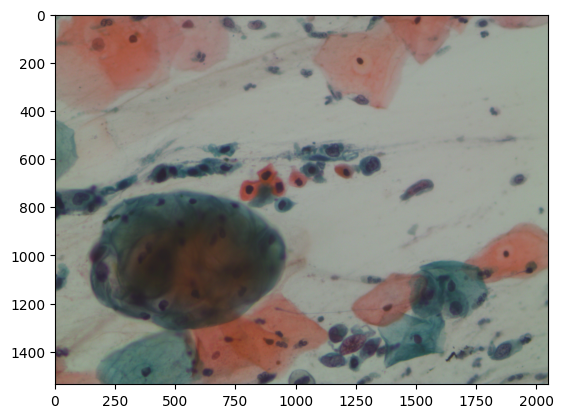

In [69]:
plt.imshow(img)
plt.show()